In [3]:
import IPython

# Lecture 9: Parallel and Concurrent Haskell 

- Concurrency with Haskell lightweight threads. [forkIO](https://hackage.haskell.org/package/base/docs/Control-Concurrent.html#v:forkIO) and [MVar](https://hackage.haskell.org/package/base/docs/Control-Concurrent-MVar.html#t:MVar).
- Synchronization between threads
- Exceptions revisited
- [Async](https://hackage.haskell.org/package/async)
- STM (Software Transaction Memory). [STM](https://hackage.haskell.org/package/base/docs/GHC-Conc.html#t:STM), [TVar](https://hackage.haskell.org/package/base/docs/GHC-Conc.html#t:TVar).
- Parallelism with Sparks. [Eval monad](https://hackage.haskell.org/package/parallel/docs/Control-Parallel-Strategies.html#v:rpar)
- Inspecting your concurrency (ThreadScope)

## Concurrency with Haskell lightweight threads. forkIO and MVar.



Хаскель неплохо оптимизирован для многопоточности(мало весят треды):

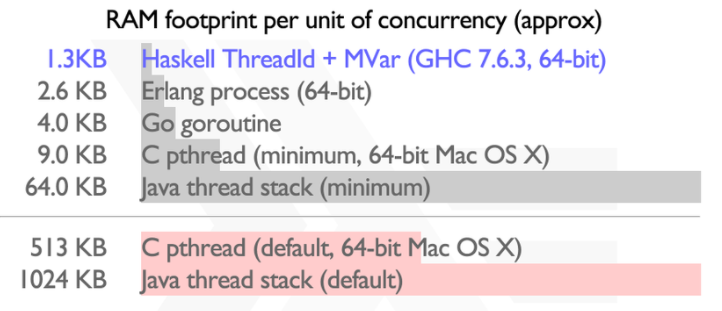

In [4]:
IPython.display.Image('drive/MyDrive/Exam/img/mem.png')

Устройство многопоточности:

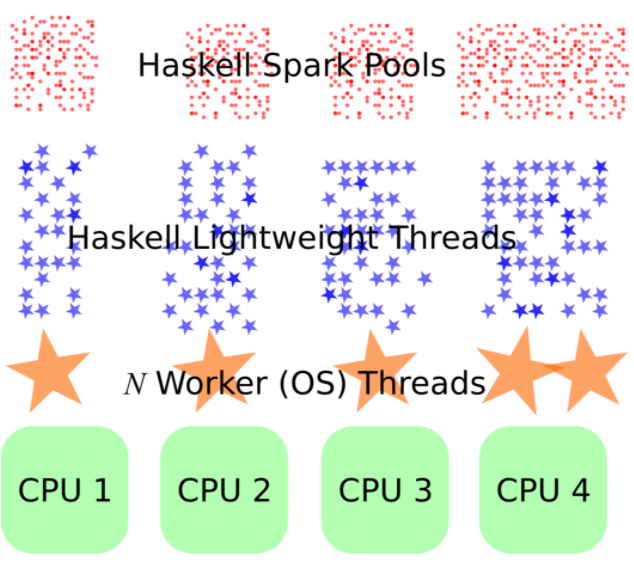

In [5]:
IPython.display.Image('drive/MyDrive/Exam/img/threads.png')

Здесь Haskell Lighteight Threads - те треды которыми мы оперируем внутри языка


## MVar & forkIO


### Создание простейших тредов:

```
forkIO :: IO () -> IO ThreadId  -- creates lightweight thread
import Control.Concurrent

main = do
  _threadId <- forkIO $ do
    threadDelay 1000000
    putStrLn "Forked thread awake"
  threadDelay 2000000
  putStrLn "Main thread finishes"
$ ghc -threaded -o test Test.hs
$ ./test +RTS -N2

Forked thread awake
Main thread finishes
```
Для использования многопоточности необходимо указать ключ -threaded, иначе все будет выполнено однопоточно

Однако т.к. это грин треды, по факту реальными тредами не явл => можем запустить и на одном треде

```
$ ghc -o test Test.hs && ./test

Forked thread awake
Main thread finishes
```


### Подобием AtomicRef в хаскеле является MVar

```
data MVar a  -- empty or full box

newEmptyMVar :: IO (MVar a)           -- create empty box
putMVar      :: MVar a -> a -> IO ()  -- fill box with value
takeMVar     :: MVar a -> IO a        -- take var with block

import Control.Concurrent

main = do
  tm1 <- newEmptyMVar
  tm2 <- newEmptyMVar
  _threadId1 <- forkIO $ do
    threadDelay 1000000
    putMVar tm1 100500
  _threadId2 <- forkIO $ do
    threadDelay 1000000
    putMVar tm2 "This is horosho"

  r1 <- takeMVar tm1
  r2 <- takeMVar tm2

  putStrLn $ "r1: " <> show r1 <> ", r2: " <> show r2

```

Если мы пытаемся положить что-то в непустой MVar - мы ждем, иначе кладем. Аналогично если пытаемся взять из пустого MVar. Это все завернуто под капот на блокировках.

MVar - это значение, защищенное мьютексом. Компилятор умеет находить некоторые ошибки, связанные с многопоточностью:

```
-- MVTest.hs

main = do
    m <- newEmptyMVar
    takeMVar m
-- throws BlockedIndefinitelyOnMVar exception
MVTest: thread blocked indefinitely in an MVar operation
-- all exceptions
BlockedIndefinitelyOnMVar
BlockedIndefinitelyOnSTM
NonTermination
Deadlock
```

## Exceptions revisited

### TreadId

До этого мы видели некий threadID. Он нужен только чтобы УБИВАТЬ УБИВАТЬ УБИВАТЬ УБИВАТЬ. Точнее отсылать в треды ексепшн о завершении:

```
throwTo :: Exception e => ThreadId -> e -> IO ()

killThread :: ThreadId -> IO ()
killThread tid = throwTo tid ThreadKilled

main = do
  tid <- forkIO myHeavyComputation
  threadDelay 1000000 -- 1 sec timeout for completion
  killThread tid
```


Так же с помощью throwTo треды можно передавать сообщения между тредами, но наверное не стоит.

Вот так можно обрабатывать ctrl+c от юзера:

```
main =
  handle intrHandler $
  flip mapM_ [1..1000] $ \i -> do
    threadDelay 1000000
    putStrLn $ "Finished round " <> show i

intrHandler :: AsyncException -> IO ()
intrHandler UserInterrupt = putStrLn "Finishing due to user interrupt ..."
intrHandler e = putStrLn $ "Caught async exception: " <> show e
```



### Synchronous исключения

Synchronous исключения - кидаются локально внутри одного треда:

```
throwIO :: Exception e => e -> IO a
throw :: Exception e => e -> a
instance  Integral Int where
  a `div` b
     | b == 0 = throw DivideByZero
     | otherwise = ...
foreign import ccall safe "HsBase.h __hscore_open"
   c_safe_open :: CFilePath -> CInt -> CMode -> IO CInt

openFile file flags mode = do
  res <- c_safe_open file flags mode
  when (res == -1) $ do
    errno <- getErrNo
    throwIO (toIOError errno file)
```

throw - упасть совсем (запустить undefined). throwIO - кинуть исключение внутри монады

### Asynchronous exceptions

Принимает id трэда куда лететь

```

throwTo :: Exception e => ThreadId -> e -> IO ()
```


### Обработка


Обрабатывать исключения можно только внутри IO монады:

```
catch :: Exception e => IO a -> (e -> IO a) -> IO a

handle :: Exception e => (e -> IO a) -> IO a -> IO a
handle = flip catch

data MyException = MyException   deriving Show
instance Exception MyException

main = do
  throwIO MyException
    `catch` \MyException -> putStrLn "Caught my IO exception"
  when (1 `div` 0 > 0) (putStrLn "not to happen")
    `catch` \e -> putStrLn $ "Caught " <> show (e :: ArithException)
  tid <- forkIO $
    (threadDelay 1000000 >> putStrLn "Done")
      `catch` \MyException -> putStrLn "Caught my async exception"
  threadDelay 500000
  throwTo tid MyException

>>out
Caught my IO exception
Caught arith exception: divide by zero
Caught my async exception
```

Обрабатывать исключения можно только внутри IO монады:
```
main = action `catch` \e -> do
         printError e
         cleanup
```
С помощью функции mask_ можно заигнорировать все пробрасываемые исключения:
```
main = action `catch` \e -> do
         printError e
         (cleanup `catch` \e -> ...)
```
Так лучше не делать никогда, потому что легко повесить себе комп.

```
main = action `catch` \e -> do
         printError e
         (mask_ cleanup)
```

Так можно отфильтровать только синхронные, а асинхронные скипать

Лучше делать так:



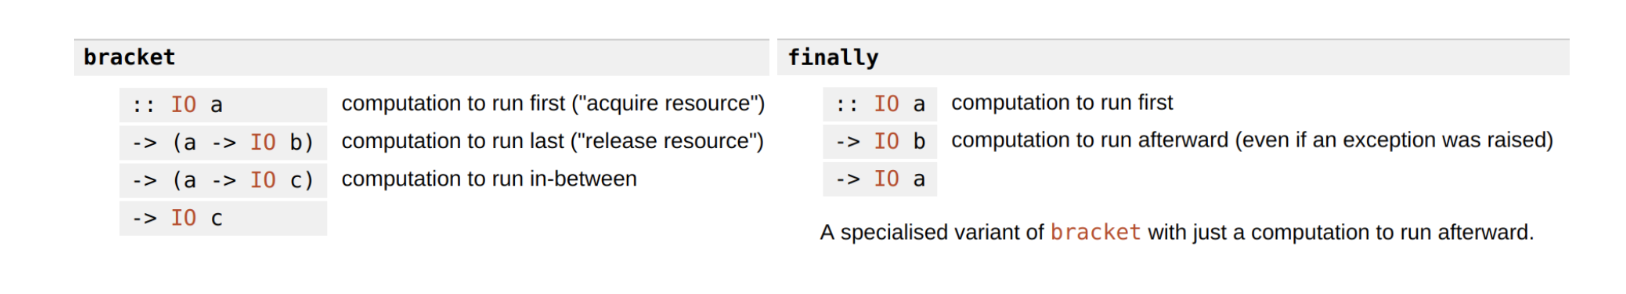

In [6]:
IPython.display.Image('drive/MyDrive/Exam/img/bracket.png')

### Итог

forkIO нужно использовать никогда, потому что много геморроя:

```
asyncExec :: IO a -> IO (MVar a)
asyncExec action = do
  mvar <- newEmptyMVar
  _tid <- forkIO (action >>= putMVar mvar)
  pure mvar

main = do
  resMV1 <- asyncExec $ do
    threadDelay 500000
    pure "foo"
  resMV2 <- asyncExec $ do
    threadDelay 500000
    pure "bar"
  (res1, res2) <- liftA2 (,) (takeMVar resMV1) (takeMVar resMV2)
  putStrLn $ "Computed " <> res1 <> " and " <> res2
```
зависнет на предпоследней строке, т.к. мы выкегнем ошибку а MVar будет ждать, не зная об этом

## Async

поэтому используем Async:

```
-- Control.Concurrent.Async
withAsync    :: IO a -> (Async a -> IO b) -> IO b
wait         :: Async a -> IO a
cancel       :: Async a -> IO ()
concurrently :: IO a -> IO b -> IO (a, b)
race         :: IO a -> IO b -> IO (Either a b)
```
concurrently - выполнить два действия параллельно и вернуть оба результата
race - запустить два действия параллельно и вернуть результат первого завершившегося
эти две функции нужны в 90% случаев, остальные не такие важные
```
worker :: Int -> IO Int  -- simulate some work
worker n = threadDelay (10^2 * n) >> return (n * n)

-- Spawn 2 threads in parallel, halt on both finished.
test1 :: IO (Int, Int)
test1 = concurrently (worker 1000) (worker 2000)

-- Spawn 2 threads in parallel, halt on first finished.
test2 :: IO (Either Int Int)
test2 = race (worker 1000) (worker 2000)

-- Spawn 10000 threads in parallel, halt on all finished.
test3 :: IO [Int]
test3 = mapConcurrently worker [0..10000]
```

## Пробуем написать банк

```
type Account = IORef Integer

transfer :: Integer -> Account -> Account -> IO ()
transfer amount from to = do
    fromVal <- readIORef from
    toVal   <- readIORef to
    writeIORef from (fromVal - amount)
    writeIORef to (toVal + amount)
```
Так нельзя (можем перезаписать то что не надо)

```
type Account = MVar Integer

credit :: Integer -> Account -> IO ()
credit amount account = do
    current <- takeMVar account
    putMVar account (current + amount)

debit :: Integer -> Account -> IO ()
debit amount account = do
    current <- takeMVar account
    putMVar account (current - amount)

transfer :: Integer -> Account -> Account -> IO ()
transfer amount from to = do
    debit amount from
    credit amount to
```

Так нельзя (можем перезаписать то что не надо)



## TVar

Условно аналог atomicRef
Работа обеспечиваеться на уровне софта а не хардвар

```
type Account = TVar Integer

credit :: Integer -> Account -> STM ()
credit amount account = do
    current <- readTVar account
    writeTVar account (current + amount)

debit :: Integer -> Account -> STM ()
debit amount account = do
    current <- readTVar account
    writeTVar account (current - amount)

transfer :: Integer -> Account -> Account -> STM ()
transfer amount from to = do
    debit amount from
    credit amount to
```
Надо так. TVar сам хендлит ошибки, действуя в бесконечном цикле

### STM

Монада для работы с многопоточностью с помощью транзакций.
Оперируем TVar-ми

```
-- import Control.Concurrent.STM
data STM a  -- software transactional memory
instance Monad STM where

atomically :: STM a -> IO a

data TVar a -- transactional variable
newTVar   :: a -> STM (TVar a)
readTVar  :: TVar a -> STM a
writeTVar :: TVar a -> a -> STM ()

retry     :: STM a                   -- try again current transaction
orElse    :: STM a -> STM a -> STM a -- if first retries then call second

throwSTM  :: Exception e => e -> STM a
catchSTM  :: Exception e => STM a -> (e -> STM a) -> STM a
```

```
transfer :: Integer -> Account -> Account -> STM ()
transfer amount from to = do
    fromVal <- readTVar from
    if (fromVal - amount) >= 0
        then do
               debit amount from
               credit amount to
        else retry
takeEitherTMVar :: TMVar a -> TMVar b -> STM (Either a b)
takeEitherTMVar ma mb =
    fmap Left  (takeTMVar ma)
      `orElse`
    fmap Right (takeTMVar mb)
```
Первый пример - зависнуть, если нет денег, второй - как писать orElse


## преймущества || хаскеля

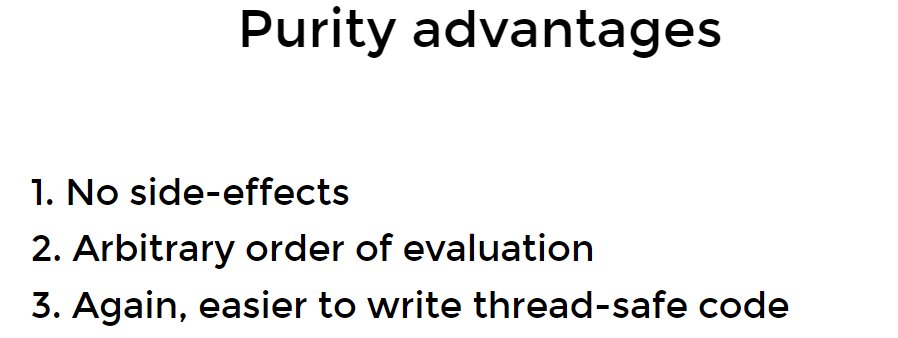

In [7]:
IPython.display.Image('drive/MyDrive/Exam/img/pos1.png')

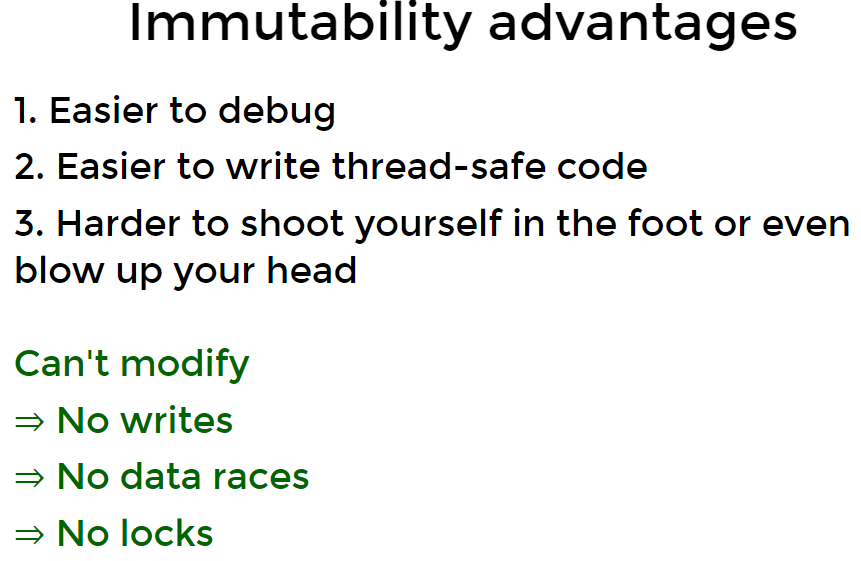

In [8]:
IPython.display.Image('drive/MyDrive/Exam/img/pos2.png')

## Parallelism with Sparks. Eval monad

хотим как то распаралелить наши ЧИСТЫЕ функции

```
data Eval a                  -- Eval is monad for parallel computation
instance Monad Eval where

runEval :: Eval a -> a  -- pull the result out of the monad

rpar :: a -> Eval a  -- suggest to parallel, create *spark* 
rseq :: a -> Eval a  -- wait for evaluation of argument (eval it to WHNF)
```

Спарк - задачки, которые исполняются паралельно. Условный хинт компилятору, что можно вычислять ||

Условно, rpar позваляет кинуть в || и за счет ленивости мы можем давольно долго ждать результат. А когда обратимся, можем подождать выполнения.

rseq - заставляет дождаться выполнения, но тоже ||. Крч сразу заджойнить

## Inspecting your concurrency (ThreadScope)

Утилита позволяющая смотреть как мы работали

```
module Main where  -- TestFib.hs

fib :: Int -> Int  -- naive fibonacci
fib 0 = 1
fib 1 = 1
fib n = fib (n - 1) + fib (n - 2)
evalFibPair :: (Int, Int)
evalFibPair = (fib 39, fib 38)

main :: IO ()
main = print evalFibPair
$ ghc -O2 -rtsopts -eventlog TestFib.hs
$ ./TestFib +RTS -s -l
```

Посмотреть:

```
$ threadscope TestFib.eventlog
```



## Итоги

Почему все не паралелим?

Т.к. все таки || занимает ресурсы => если просто все будем паралелить - плохо

